<a href="https://colab.research.google.com/github/dipayandas97/EEG-Analysis/blob/master/MU_dwt_models_contd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

data_path = '/content/drive/My Drive/AI_datasets/MW/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pickle 

w = open(data_path+'MU_X_real', 'rb')
X_real_series = pickle.load(w)
w.close()
len(X_real_series)

40983

In [0]:
import pickle 

q = open(data_path+'MU_final_Y', 'rb')
Y_hot = pickle.load(q)
q.close()
Y_hot.shape

(40983, 11)

In [0]:
#create real series of 512 time steps
from keras.preprocessing.sequence import pad_sequences

X_real_padded = np.zeros((len(X_real_series),4,512))

for s in range(len(X_real_series)):
  X_real_padded[s] = pad_sequences(X_real_series[s], padding='post', maxlen = 512, value=np.mean(X_real_series[s]))

Using TensorFlow backend.


In [0]:
import pywt
import itertools
import cv2

lv = 8
max_time_steps = 256
data = []

for s in range(X_real_padded.shape[0]):
  sample_=[]
  for e in range(4):
    dwt = pywt.wavedec(X_real_padded[s][e], 'db1', level=lv)
    
    img = []
    for i in range(len(dwt)): # 9
      t = [x for x in list(itertools.chain.from_iterable(itertools.repeat(x, max_time_steps//len(dwt[i])) for x in dwt[i]))]
      img.append(np.asarray(t))
    sample_.append(cv2.resize(np.asarray(img[1:]), (32,32)))
  sample_ = np.asarray(sample_) + abs(np.min(np.asarray(sample_)))
  sample_ = sample_ / np.max(sample_)
  data.append(sample_)
  print(s)
data = np.asarray(data)

In [0]:
data.shape

(40983, 4, 32, 32)

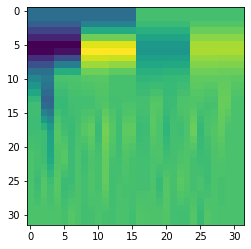

In [0]:
plt.imshow(data[0][0])

In [0]:
print('Max: ', np.max(data))
print('Min: ', np.min(data))
print('Mean: ', np.mean(data))
print('Std: ', np.std(data))

Max:  1.0
Min:  0.0
Mean:  0.5040510697256819
Std:  0.17850077831510153


In [0]:
import pickle 

e = open(data_path+'MU_32x32_dwt_X', 'wb')
pickle.dump(data, e)
e.close()

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, Y_hot, test_size=0.2, shuffle=True)

In [0]:
from keras.models import Model
from keras.layers import *

v = Input(shape=(4, 32, 32))
x = Conv2D(50, (3,3), activation = 'relu', data_format='channels_first')(v)
x = MaxPooling2D(2,2)(x)
x = Conv2D(25, (3,3), activation = 'relu')(x)
x = MaxPooling2D(2,2)(x)
x = Conv2D(20, (2,2), activation = 'relu')(x)
x = MaxPooling2D(2,2)(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dense(11, activation = 'softmax')(x)
net = Model(v,x)
net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
net.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 4, 32, 32)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 50, 30, 30)        1850      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 25, 15, 30)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 23, 13, 25)        6775      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 11, 6, 25)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 5, 20)         2020      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 5, 2, 20)          0   

In [0]:
net.fit(data, Y_hot, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

Train on 32786 samples, validate on 8197 samples
Epoch 1/50
32786/32786 [==============================] - 11s 341us/step - loss: 2.1825 - acc: 0.1724 - val_loss: 0.4280 - val_acc: 0.9589
Epoch 2/50
32786/32786 [==============================] - 11s 342us/step - loss: 2.1705 - acc: 0.1779 - val_loss: 0.2568 - val_acc: 0.9894
Epoch 3/50
32786/32786 [==============================] - 11s 342us/step - loss: 2.1648 - acc: 0.1774 - val_loss: 0.3321 - val_acc: 0.9652
Epoch 4/50
32786/32786 [==============================] - 11s 335us/step - loss: 2.1582 - acc: 0.1794 - val_loss: 0.5375 - val_acc: 0.9405
Epoch 5/50
32786/32786 [==============================] - 11s 340us/step - loss: 2.1544 - acc: 0.1827 - val_loss: 0.3550 - val_acc: 0.9611
Epoch 6/50
27168/32786 [=======================>......] - ETA: 1s - loss: 2.1516 - acc: 0.1833

KeyboardInterrupt: ignored

In [0]:
pred.shape

(40983, 11)

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix
chunk =X_test
pred = net.predict(chunk)
true = y_test
pred_ = [np.argmax(x) for x in pred]
true_ = [np.argmax(x) for x in true]
accuracy_score(true_, pred_)

0.3691744611630744

In [0]:
from keras.models import Model
from keras.layers import *

v = Input(shape=(4, 32, 32))
x = Conv2D(50, (3,3), activation = 'relu', data_format='channels_first')(v)
x = Dropout(0.2)(x)
x = MaxPooling2D(2,2)(x)
x = Conv2D(25, (3,3), activation = 'relu')(x)
x = MaxPooling2D(2,2)(x)
x = Conv2D(20, (2,2), activation = 'relu')(x)
x = Dropout(0.2)(x)
x = MaxPooling2D(2,2)(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(11, activation = 'softmax')(x)
net2 = Model(v,x)
net2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
net2.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 4, 32, 32)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 50, 30, 30)        1850      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 30, 30)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 25, 15, 30)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 23, 13, 25)        6775      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 11, 6, 25)         0         
_________

In [0]:
net2.fit(X_train, y_train, epochs=50, batch_size=50, shuffle=True, validation_data=(X_test, y_test))

Train on 32786 samples, validate on 8197 samples
Epoch 1/50
32786/32786 [==============================] - 11s 333us/step - loss: 2.0972 - acc: 0.2907 - val_loss: 1.8725 - val_acc: 0.3323
Epoch 2/50
32786/32786 [==============================] - 9s 287us/step - loss: 1.8391 - acc: 0.3297 - val_loss: 1.8558 - val_acc: 0.3326
Epoch 3/50
32786/32786 [==============================] - 10s 293us/step - loss: 1.8134 - acc: 0.3315 - val_loss: 1.8132 - val_acc: 0.3341
Epoch 4/50
32786/32786 [==============================] - 9s 289us/step - loss: 1.7945 - acc: 0.3349 - val_loss: 1.8016 - val_acc: 0.3329
Epoch 5/50
32786/32786 [==============================] - 9s 288us/step - loss: 1.7812 - acc: 0.3359 - val_loss: 1.7815 - val_acc: 0.3366
Epoch 6/50
32786/32786 [==============================] - 10s 291us/step - loss: 1.7710 - acc: 0.3397 - val_loss: 1.7684 - val_acc: 0.3359
Epoch 7/50
32786/32786 [==============================] - 9s 284us/step - loss: 1.7686 - acc: 0.3368 - val_loss: 1.7623 

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix
chunk =X_test
pred = net2.predict(chunk)
true = y_test
pred_ = [np.argmax(x) for x in pred]
true_ = [np.argmax(x) for x in true]
accuracy_score(true_, pred_)
#confusion_matrix(true_, pred_)

0.345370257411248

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix
chunk =X_test
pred = net2.predict(chunk)
true = y_test
pred_ = [np.argmax(x) for x in pred]
true_ = [np.argmax(x) for x in true]
accuracy_score(true_, pred_)
#confusion_matrix(true_, pred_)

0.33963645236061973

In [0]:
data_ = [x.reshape(1, x.shape[0], x.shape[1], x.shape[2]) for x in data]

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.asarray(data_), Y_hot, test_size=0.2, shuffle=True)

In [0]:
from keras.models import Model
from keras.layers import *

v = Input(shape=(1, 4, 32, 32))
x = Conv3D(50, (2,3,3), activation = 'relu', data_format='channels_first')(v)
x = Conv3D(25, 2, activation = 'relu')(x)
x = Conv3D(20, 2, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(11, activation = 'softmax')(x)
net3 = Model(v,x)
net3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
net3.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 1, 4, 32, 32)      0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 50, 3, 30, 30)     950       
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 49, 2, 29, 25)     6025      
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 48, 1, 28, 20)     4020      
_________________________________________________________________
dropout_11 (Dropout)         (None, 48, 1, 28, 20)     0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 26880)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               268

In [0]:
net3.fit(X_train,y_train,epochs=50,batch_size=50,shuffle=True, validation_data=(X_test,y_test))

Train on 32786 samples, validate on 8197 samples
Epoch 1/50
32786/32786 [==============================] - 26s 799us/step - loss: 1.8973 - acc: 0.3218 - val_loss: 1.8027 - val_acc: 0.3384
Epoch 2/50
32786/32786 [==============================] - 24s 737us/step - loss: 1.7965 - acc: 0.3362 - val_loss: 1.7841 - val_acc: 0.3381
Epoch 3/50
32786/32786 [==============================] - 24s 734us/step - loss: 1.7763 - acc: 0.3384 - val_loss: 1.7596 - val_acc: 0.3359
Epoch 4/50
32786/32786 [==============================] - 24s 727us/step - loss: 1.7590 - acc: 0.3397 - val_loss: 1.7482 - val_acc: 0.3394
Epoch 5/50
32786/32786 [==============================] - 24s 723us/step - loss: 1.7453 - acc: 0.3422 - val_loss: 1.7425 - val_acc: 0.3374
Epoch 6/50
32786/32786 [==============================] - 24s 728us/step - loss: 1.7417 - acc: 0.3452 - val_loss: 1.7537 - val_acc: 0.3417
Epoch 7/50
32786/32786 [==============================] - 24s 729us/step - loss: 1.7353 - acc: 0.3456 - val_loss: 1.7

In [0]:
from keras.models import Model
from keras.layers import *

v = Input(shape=(1, 4, 32, 32))
x = Conv3D(25, (2,3,3), activation = 'relu', data_format='channels_first')(v)
x = Conv3D(15, 2, activation = 'relu')(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(11, activation = 'softmax')(x)
net4 = Model(v,x)
net4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
net4.summary()
net4.fit(X_train,y_train,epochs=50,batch_size=50,shuffle=True, validation_data=(X_test,y_test))

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 1, 4, 32, 32)      0         
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 25, 3, 30, 30)     475       
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 24, 2, 29, 15)     3615      
_________________________________________________________________
flatten_12 (Flatten)         (None, 20880)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)               2088100   
_________________________________________________________________
dense_29 (Dense)             (None, 32)                3232      
_________________________________________________________________
dense_30 (Dense)             (None, 11)                363